# V471TAU

## Differential Rotation 

The parameters that will be used in each epoch are:

|           Parameter   | 2004       |  2005     |
|              :---:    | :---:      | :---:     |
|$K$ (km/s)             | $149.3$    | $149.3$   |  
|$v_\mathrm{rad}$ (km/s)| $35.$     | $35.$    |
|$\phi$                 | $-0.0040$  | $-0.0035$ | 
| $i$                   | $78.755$ | $78.755$      |
|$v\sin(i)$ (km/s)      | $89.3$     |  $89.3$   |
| EQW                   | $5.12$     | $5.12$    |


In [1]:
lev_o = (12.05,12.180)
lev_do = (0.00, 300)
sigma_errorbar=1

### DATA IN 2004  
  \begin{equation*} SP_{\mathrm{ph}} = 0.146 \end{equation*}

In [2]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager
import copy
from matplotlib.ticker import MultipleLocator

#P.style.use(['seaborn-white', 'seaborn-paper', 'seaborn-ticks'])
#matplotlib.rc("font", family="Times New Roman", size=20)
#matplotlib.rc('xtick', labelsize='medium')
#matplotlib.rc('ytick', labelsize='medium')

P.style.use(['seaborn-white', 'seaborn-paper', 'seaborn-ticks'])
matplotlib.rc("font", family="Times New Roman", size=18)
matplotlib.rc('xtick', labelsize='large')
matplotlib.rc('ytick', labelsize='large')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Define the number of sigmas that you want to consider 
nsigma=5.

# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_DRi_chipot_2004.txt', unpack=True)


#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
#print(Omega0)
Oeq = (1 - beta)*Omega0
dO = gamma*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_04.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
print('n points =', count)
    
#Compute the corresponding variation in "reduced chisq"
dchisq = nsigma**2*2.3/count

#select data within the conditions:
isp = N.bitwise_and(N.bitwise_and(sp_ph <= 0.1465, sp_ph >= 0.1455), test <=0.005)
Oeq = Oeq[isp]; dO = dO[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Set global min of spot coverage
vmin = chisq.min()
print('chisqr min =', vmin)

#Set levels for plotting
lev = [vmin + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [vmin + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#we also add another condition for the data (optional):
ic = N.bitwise_and(chisq >= vmin, chisq <= (vmin + cut_sigma**2*2.3/count))
Oeq = Oeq[ic]; dO = dO[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]


# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(Oeq), N.unique(dO))
#m_z = N.ones_like(x)*9999.
#m_test = N.ones_like(x)*9999.
#for i in range(sp_ph.shape[0]):
#    indx = N.bitwise_and(x == Oeq[i], y == dO[i])
#    m_z[indx] = sp_ph[i]
#    m_test[indx] = test[i]
#mask = m_z > (vmin + int(nsigma+2))
#z=N.ma.array(m_z, mask=mask)  
#mask1 = m_test >= 1.
#c_test=N.ma.array(m_test, mask=mask1)  

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(Oeq, dO)
interpolator = tri.LinearTriInterpolator(triang, chisq)
z = interpolator(x, y)
interpolator_test = tri.LinearTriInterpolator(triang, test)
c_test = interpolator_test(x, y)


print(' Number of points in the fit: ', Oeq.shape[0])
print('\n The lowest Chi2 in the data was', vmin, 'at:')
print('Oeq = ', Oeq[chisq.argmin()], 'dO = ', dO[chisq.argmin()],"\n")

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq**2 + x[1]*Oeq + x[2]*dO**2 + x[3]*dO \
                            + x[4]*Oeq*dO + x[5] - chisq
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx *= 1./N.sqrt(count)
dy *= 1./N.sqrt(count)

w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res = a*Oeq**2 + b*Oeq + c*dO**2 + d*dO + e*Oeq*dO + f - chisq


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.3f and d(dO) = %1.3f \n' %(dx, dy))


thc = N.arccos(N.sqrt((best_x-Omega0)/best_y))
dthc = 1./(1 - (best_x - Omega0)/best_y)*N.sqrt((1./2./best_y/N.sqrt((best_x - Omega0)/best_y)*dx)**2 + ((best_x - Omega0)/2./best_y**2/N.sqrt((best_x - Omega0)/best_y)*dy)**2)


print('(theta_c) = %d +- %d \n' %(thc*180./N.pi, dthc*180./N.pi) )


cos2theta_04I = e/(c-a-N.sqrt((a-c)**2 + e**2))
ws_04I = best_x - best_y*(cos2theta_04I)
print(r'cos2(theta_s) = %.3f' %(cos2theta_04I))
print('(theta_s) = %.3f ' %(N.arccos(N.sqrt(cos2theta_04I))*180./N.pi))
print('(Omega_s) = %.3f \n' %(ws_04I))


thetas_wiki = N.arctan(e/(c-a))/2.
print('(theta_s) = %.3f \n' %(N.arccos(N.sqrt(N.tan(thetas_wiki)))*180./N.pi))

print('beta = %.8f and gamma = %.8f \n' %(1.- best_x/Omega0, best_y/Omega0))

Oeq04 = best_x; dO04 = best_y
dOeq04 = dx; ddO04 = dy

print('Min chisq from fit:')
print('Min chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

n points = 27572
chisqr min = 1.0014
 Number of points in the fit:  126

 The lowest Chi2 in the data was 1.0014 at:
Oeq =  12.104000055174232 dO =  0.09699994574170735 

Position of the center on this plane:
Omega_EQ = 12.106 and dO = 0.100
dOeq = 0.001 and d(dO) = 0.005 

(theta_c) = 44 +- 2 

cos2(theta_s) = 0.180
(theta_s) = 64.920 
(Omega_s) = 12.088 

(theta_s) = 64.920 

beta = -0.00418488 and gamma = 0.00827201 

Min chisq from fit:
Min chisq =  1.0013719425533054
RMS =  0.00010846099795136207
RMS x dchisq = 1.300211580658676


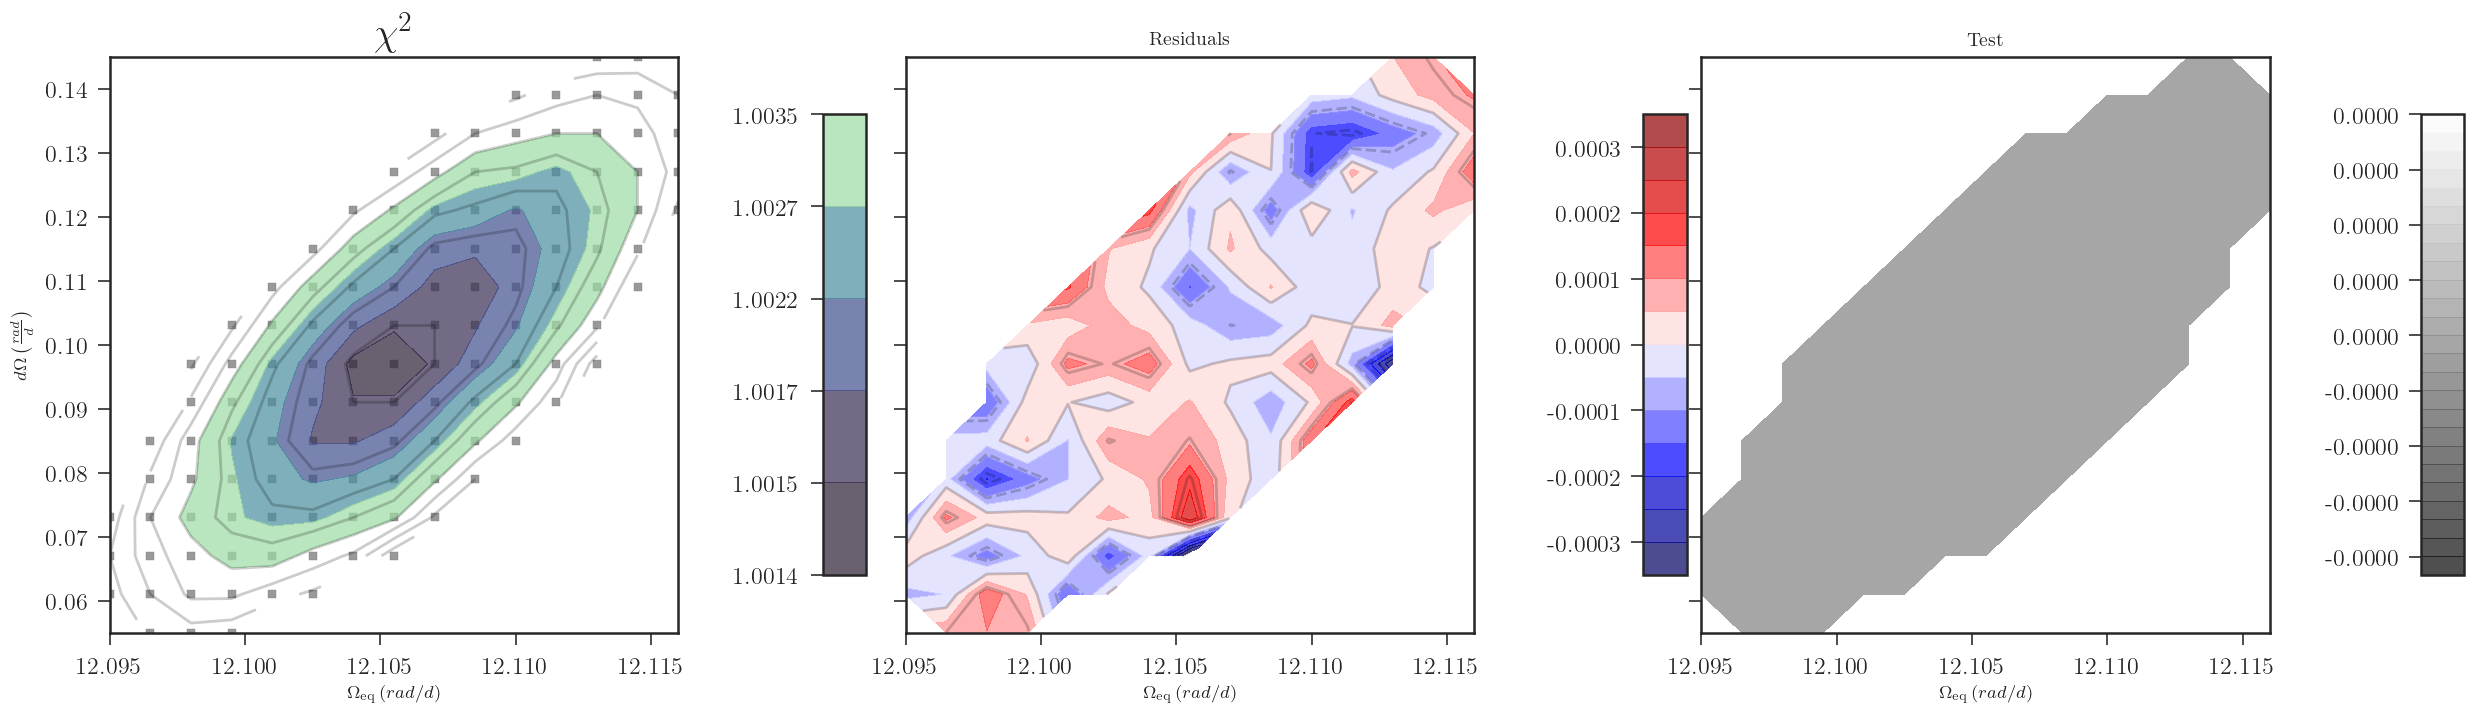

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import copy


cmap = copy.copy(cmocean.cm.deep_r)

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
#ax[0].scatter(x, y, marker = 's', s=20, color='gray', alpha=0.8)
ax[0].scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax[0].set_title(r'$\chi^2$', fontsize=20)
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$')

# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

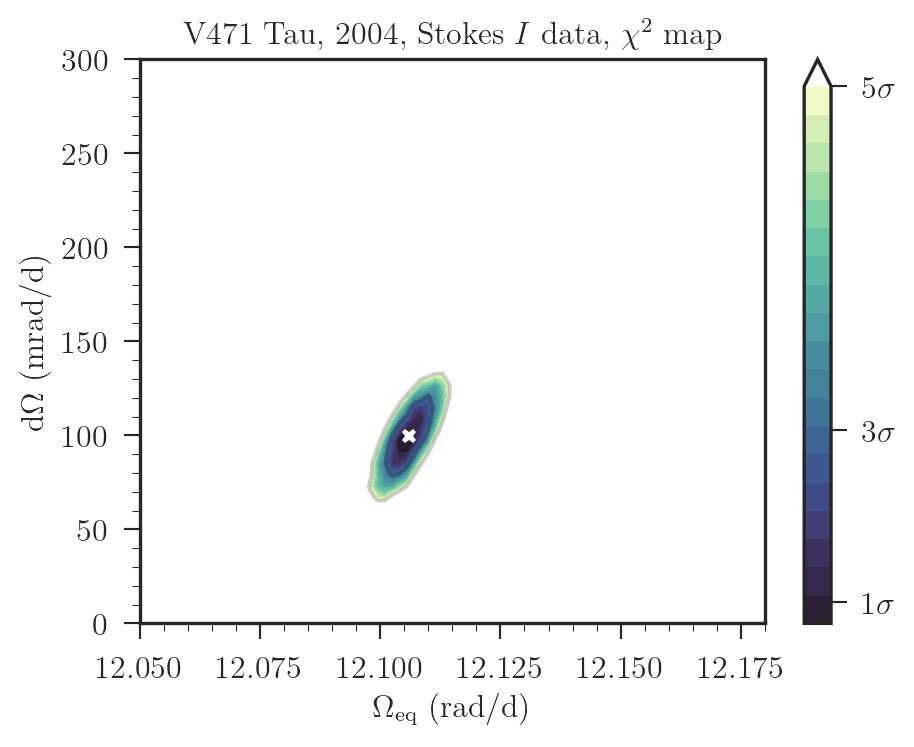

In [4]:
fig, ax = P.subplots(1,1, figsize=(5,4), dpi=96)
#ax.scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'V471 Tau, 2004, Stokes $I$ data, $\chi^2$ map', fontsize='large')
im = ax.contourf(x, 1.e3*y, z, levels=N.linspace(lev[0], lev[-1], 20), cmap=cmap, alpha=1., extend='max')
im.cmap.set_over('white')
ax.contour(x, 1.e3*y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
#ax.set_xlim((12.091,12.119)); ax.set_ylim((0.037,0.151))
ax.plot(best_x, 1.e3*best_y, 'X', color='w')
#ax.errorbar(best_x, best_y, xerr=dx, yerr=dy, color='r')
ax.set_ylabel(r'$\mathrm{d}\Omega$ (mrad/d)', fontsize='large')
ax.set_xlabel(r'$\Omega_\mathrm{eq}$ (rad/d)', fontsize='large')
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(.005))
P.xticks(fontsize='large')
P.yticks(fontsize='large')
P.tight_layout()
P.savefig('figs/dr_i_chipot_2004.pdf', rasterized=True)

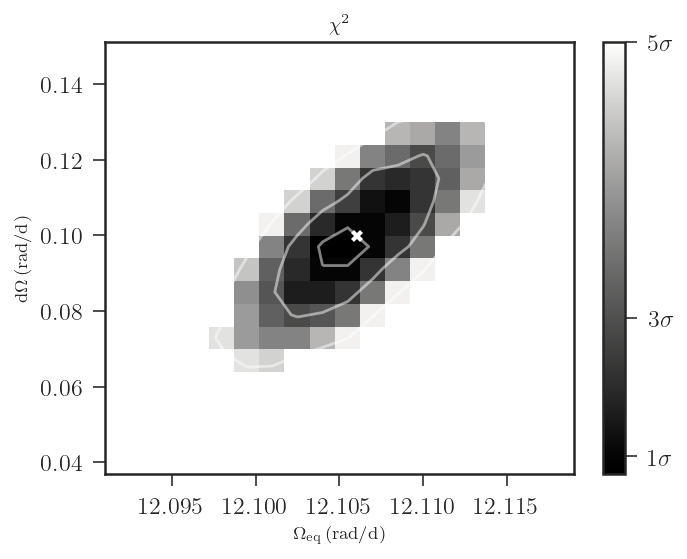

In [5]:
fig, ax = P.subplots(1,1, figsize=(5,4))
ax.set_title(r'$\chi^2$')
x_l = N.unique(Oeq)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(dO)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=copy.copy(cm.cm.gray), alpha=1.)
im.cmap.set_over('white')
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.set_xlim((12.091,12.119)); ax.set_ylim((0.037,0.151))
ax.plot(best_x, best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega \left(\mathrm{rad/d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(\mathrm{rad/d}\right)$')
P.tight_layout()

### Stokes $V$ 
\begin{equation*} |B_{\mathrm{aim}}| = 131 \end{equation*}

In [6]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

#Define the number of sigmas that you want to consider 
nsigma=1.99999999

# Read file with informations in each run
beta_v, gamma_v, chisq_v, s_v, bmod, test_v = N.genfromtxt('data/search_DRv_chipot_2004.txt', unpack=True)


#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
Oeq_v = (1 - beta_v)*Omega0
dO_v = gamma_v*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_04.ss')

count=0
for i in range(len(cycleV)):
    count += V[i].shape[0]
print('n points =', count)

#Compute the corresponding variation in "reduced chisq"
dchisq_v = nsigma**2*2.3/count

#select data within the conditions:
isp = N.bitwise_and(N.bitwise_and(bmod <= 131.05, bmod >= 130.95), test_v <=0.005)
Oeq_v = Oeq_v[isp]; dO_v = dO_v[isp]; chisq_v = chisq_v[isp]; s_v = s_v[isp]; bmod = bmod[isp] 
test_v = test_v[isp]

# Set global min of spot coverage
vmin_v = chisq_v.min()
print(vmin_v)
#Set levels for plotting
lev_v = [vmin_v + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma= int(nsigma) + 2
lev_1_v = [vmin_v + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#we also add another condition for the data (optional):
ic_v = N.bitwise_and(chisq_v >= vmin_v, chisq_v <= (vmin_v + cut_sigma**2*2.3/count))
Oeq_v = Oeq_v[ic_v]; dO_v = dO_v[ic_v]; chisq_v = chisq_v[ic_v]; s_v = s_v[ic_v]; bmod = bmod[ic_v] 
test_v = test_v[ic_v]

# Create a mesh and create new matrix with mesh's shape
x_v, y_v = N.meshgrid(N.unique(Oeq_v), N.unique(dO_v))
m_z_v = N.ones_like(x_v)*9999.
m_test_v = N.ones_like(x_v)*9999.
for i in range(chisq_v.shape[0]):
    indx = N.bitwise_and(x_v == Oeq_v[i], y_v == dO_v[i])
    m_z_v[indx] = chisq_v[i]
    m_test_v[indx] = test_v[i]
mask_v = m_z_v > (vmin_v + cut_sigma**2*2.3/count)
z_v=N.ma.array(m_z_v, mask=mask_v)  
mask1_v = m_test_v >= 1.
c_test_v=N.ma.array(m_test_v, mask=mask1_v) 

print(' Number of points in the fit: ', Oeq_v.shape[0])
print('\n The lowest Chi2 in the data was at:')
print('Oeq = ', Oeq_v[chisq_v.argmin()], 'dO = ', dO_v[chisq_v.argmin()])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq_v**2 + x[1]*Oeq_v + x[2]*dO_v**2 + x[3]*dO_v \
                            + x[4]*Oeq_v*dO_v + x[5] - chisq_v
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx *= sigma_errorbar/N.sqrt(count)
dy *= sigma_errorbar/N.sqrt(count)

w_min_v = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res_v = a*Oeq_v**2 + b*Oeq_v + c*dO_v**2 + d*dO_v + e*Oeq_v*dO_v + f - chisq_v


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.3f and d(dO) = %1.3f \n' %(dx, dy))


thc = N.arccos(N.sqrt((best_x-Omega0)/best_y))
dthc = 1./(1 - (best_x - Omega0)/best_y)*N.sqrt((1./2./best_y/N.sqrt((best_x - Omega0)/best_y)*dx)**2 + ((best_x - Omega0)/2./best_y**2/N.sqrt((best_x - Omega0)/best_y)*dy)**2)

print('(theta_c) = %d +- %d \n' %(thc*180./N.pi, dthc*180./N.pi) )


cos2theta_04V = e/(c-a-N.sqrt((a-c)**2 + e**2))
ws_04V = best_x - best_y*(cos2theta_04V)
print(r'cos2(theta_s) = %.3f' %(cos2theta_04V))
print('(theta_s) = %.3f ' %(N.arccos(N.sqrt(cos2theta_04V))*180./N.pi))
print('(Omega_s) = %.3f \n' %(ws_04V))


thetas_wiki = N.arctan(e/(c-a))/2.
print('(theta_s) = %.3f \n' %(N.arccos(N.sqrt(N.tan(thetas_wiki)))*180./N.pi))

print(r'beta = %.8f and gamma = %.8f' %(1.- best_x/Omega0, best_y/Omega0))

Oeq04V = best_x; dO04V = best_y
dOeq04V = dx; ddO04V = dy

print('\n Min chisq from fit:')
print('Min chisq = ', w_min_v)
print('RMS = ', N.sqrt(N.mean(res_v**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res_v**2))*(count/2.3)) #2params

n points = 6344
1.0197
 Number of points in the fit:  273

 The lowest Chi2 in the data was at:
Oeq =  12.11499995829342 dO =  0.12000000620429534
Position of the center on this plane:
Omega_EQ = 12.116 and dO = 0.129
dOeq = 0.008 and d(dO) = 0.023 

(theta_c) = 46 +- 8 

cos2(theta_s) = 0.298
(theta_s) = 56.930 
(Omega_s) = 12.078 

(theta_s) = 56.930 

beta = -0.00500182 and gamma = 0.01068181

 Min chisq from fit:
Min chisq =  1.0197788474138179
RMS =  0.00011077387392552913
RMS x dchisq = 0.30554324181893777


In [7]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

#Define the number of sigmas that you want to consider 
nsigma=5.

# Read file with informations in each run
beta_v, gamma_v, chisq_v, s_v, bmod, test_v = N.genfromtxt('data/search_DRv_chipot_2004.txt', unpack=True)


#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
Oeq_v = (1 - beta_v)*Omega0
dO_v = gamma_v*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_04.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
#Compute the corresponding variation in "reduced chisq"
dchisq_v = nsigma**2*2.3/count

#select data within the conditions:
isp = N.bitwise_and(N.bitwise_and(bmod <= 131.05, bmod >= 130.95), test_v <=0.005)
Oeq_v = Oeq_v[isp]; dO_v = dO_v[isp]; chisq_v = chisq_v[isp]; s_v = s_v[isp]; bmod = bmod[isp] 
test_v = test_v[isp]

# Set global min of spot coverage
vmin_v = chisq_v.min()
print(vmin_v)
#Set levels for plotting
lev_v = [vmin_v + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma= int(nsigma) + 2
lev_1_v = [vmin_v + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#we also add another condition for the data (optional):
ic_v = N.bitwise_and(chisq_v >= vmin_v, chisq_v <= (vmin_v + cut_sigma**2*2.3/count))
Oeq_v = Oeq_v[ic_v]; dO_v = dO_v[ic_v]; chisq_v = chisq_v[ic_v]; s_v = s_v[ic_v]; bmod = bmod[ic_v] 
test_v = test_v[ic_v]

# Create a mesh and create new matrix with mesh's shape
x_v, y_v = N.meshgrid(N.unique(Oeq_v), N.unique(dO_v))
m_z_v = N.ones_like(x_v)*9999.
m_test_v = N.ones_like(x_v)*9999.
for i in range(chisq_v.shape[0]):
    indx = N.bitwise_and(x_v == Oeq_v[i], y_v == dO_v[i])
    m_z_v[indx] = chisq_v[i]
    m_test_v[indx] = test_v[i]
mask_v = m_z_v > (vmin_v + cut_sigma**2*2.3/count)
z_v=N.ma.array(m_z_v, mask=mask_v)  
mask1_v = m_test_v >= 1.
c_test_v=N.ma.array(m_test_v, mask=mask1_v) 


1.0197


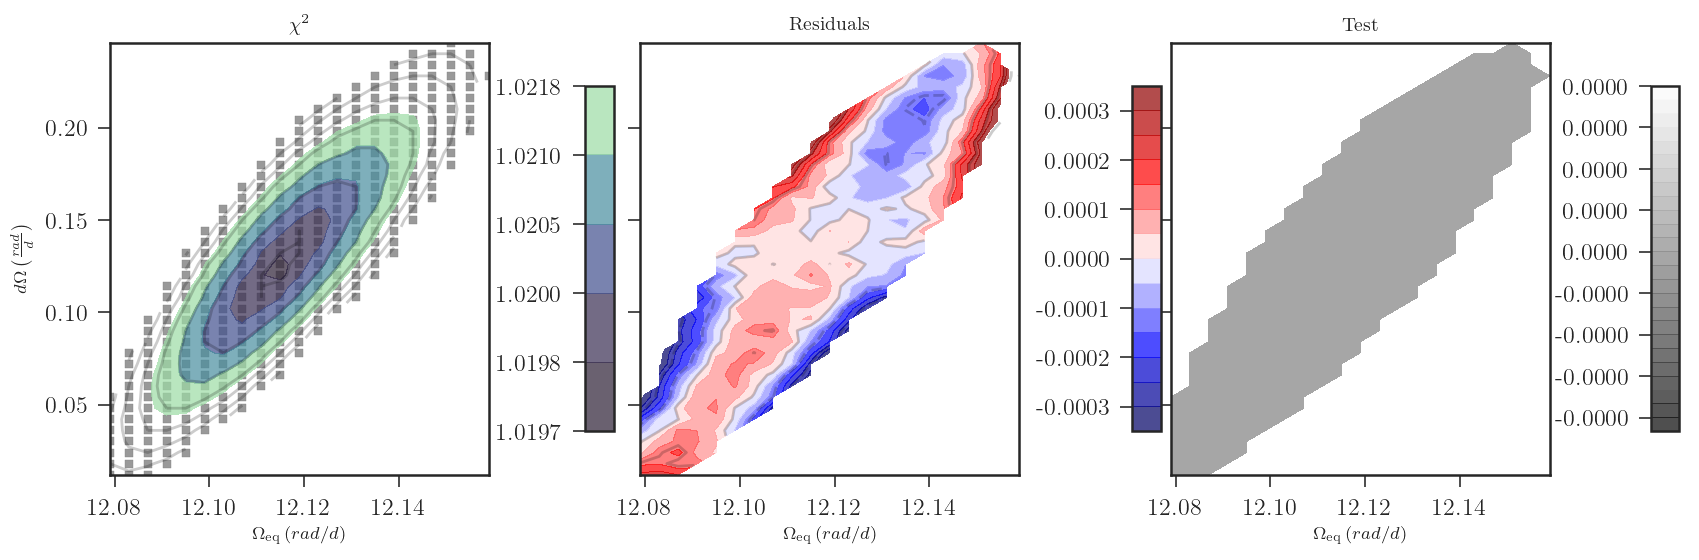

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean


fig, ax = P.subplots(1,3, figsize=(10,3), sharey=True)
ax[0].scatter(Oeq_v, dO_v, marker = 's', s=20, color='gray', alpha=0.8)
#ax[0].scatter(x_v, y_v, c=z_v, marker = 's', s=20, alpha=1.)
ax[0].set_title(r'$\chi^2$')
im = ax[0].contourf(x_v, y_v, z_v, levels=lev_v, cmap=cmap, alpha=0.7)
ax[0].contour(x_v, y_v, z_v, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x_v.min(), x_v.max()))
ax[0].set_ylim((y_v.min(), y_v.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$')

# Residual
res_v = a*x_v**2 + b*x_v + c*y_v**2 + d*y_v + e*x_v*y_v + f - z_v
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x_v, y_v, res_v, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x_v, y_v, res_v, colors='k', alpha=0.2)
ax[1].set_xlim((x_v.min(), x_v.max()))
ax[1].set_ylim((y_v.min(), y_v.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x_v, y_v, c_test_v, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x_v.min(), x_v.max()))
ax[2].set_ylim((y_v.min(), y_v.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$')
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

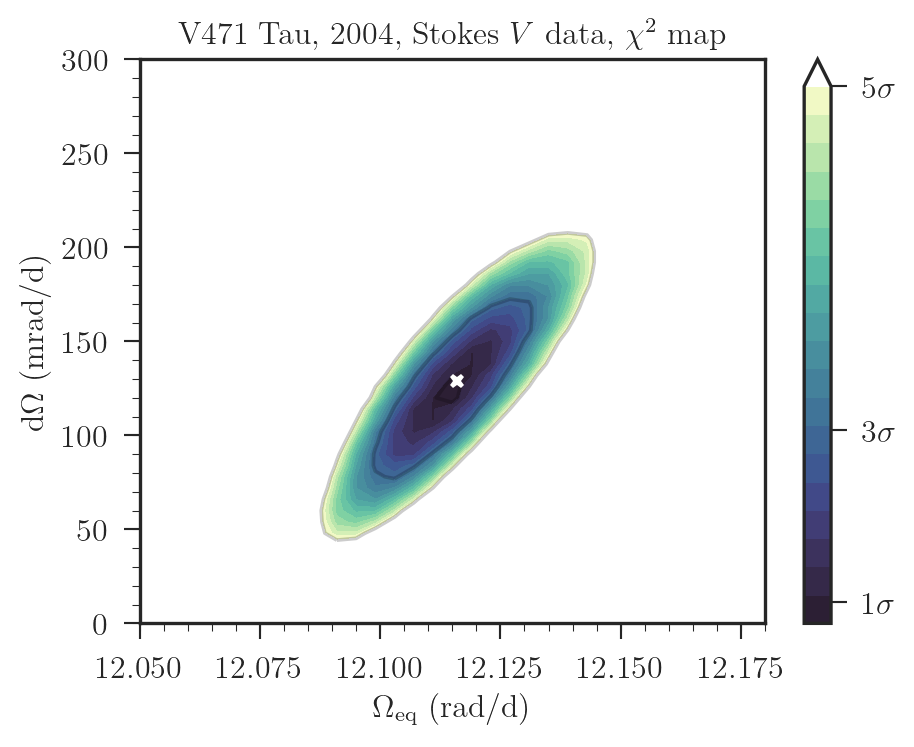

In [9]:
fig, ax = P.subplots(1,1, figsize=(5,4), dpi=96)
#ax.scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'V471 Tau, 2004, Stokes $V$ data, $\chi^2$ map', fontsize='large')
im = ax.contourf(x_v, 1.e3*y_v, z_v, levels=N.linspace(lev_v[0], lev_v[-1], 20), cmap=cmap, alpha=1., extend='max')
im.cmap.set_over('white')
ax.contour(x_v, 1.e3*y_v, z_v, levels=lev_1_v, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1_v, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.plot(best_x, 1.e3*best_y, 'X', color='w')
#ax.errorbar(best_x, best_y, xerr=dx, yerr=dy, color='r')
ax.set_ylabel(r'$\mathrm{d}\Omega$ (mrad/d)', fontsize='large')
ax.set_xlabel(r'$\Omega_\mathrm{eq}$ (rad/d)', fontsize='large')
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(.005))
P.xticks(fontsize='large')
P.yticks(fontsize='large')
P.tight_layout()
P.savefig('figs/dr_v_chipot_2004.pdf', rasterized=True)

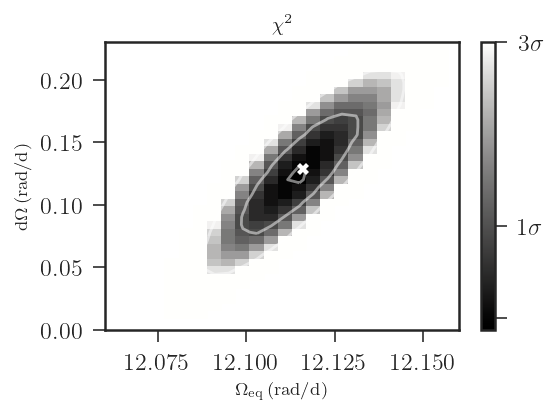

In [10]:
fig, ax = P.subplots(1,1, figsize=(4,3))
ax.set_title(r'$\chi^2$')
x_l = N.unique(Oeq_v)[0:2]
dx_v = (x_l[1] - x_l[0])/2.
y_l = N.unique(dO_v)[0:2]
dy_v = (y_l[1] - y_l[0])/2.
im_v = ax.pcolormesh(x_v-dx_v, y_v-dy_v, z_v, vmin=lev_v[0], vmax=lev_v[-1], cmap=copy.copy(cm.cm.gray), alpha=1.)
im.cmap.set_over('white')
ax.contour(x_v, y_v, z_v, levels=lev_1_v, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im_v, ticks=lev_1_v, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels(['']+[r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.set_xlim((12.06,12.16)); ax.set_ylim((0.00,0.23))
ax.plot(best_x, best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega \left(\mathrm{rad/d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(\mathrm{rad/d}\right)$')
P.tight_layout()

### DATA IN 2005  
  \begin{equation*} SP_{\mathrm{ph}} = 0.18 \end{equation*}

In [11]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

#Define the number of sigmas that you want to consider 
nsigma = 11.

# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_DRi_chipot_2005.txt', unpack=True)


#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
print(Omega0)
Oeq = (1 - beta)*Omega0
dO = gamma*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_05.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
print('N points =', count)
    
#Compute the corresponding variation in "reduced chisq"
dchisq = nsigma**2*2.3/count

#select data within the conditions:
isp = N.bitwise_and(N.bitwise_and(sp_ph <= 0.18050, sp_ph >= 0.17950), test <=0.005)
Oeq = Oeq[isp]; dO = dO[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Set global min of spot coverage
vmin = chisq.min()
print(vmin)

#Set levels for plotting
lev = [vmin + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [vmin + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#we also add another condition for the data (optional):
ic = N.bitwise_and(chisq >= vmin, chisq <= (vmin + cut_sigma**2*2.3/count))
Oeq = Oeq[ic]; dO = dO[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(Oeq), N.unique(dO))
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(chisq.shape[0]):
    indx = N.bitwise_and(x == Oeq[i], y == dO[i])
    m_z[indx] = chisq[i]
    m_test[indx] = test[i]
mask = m_z > (vmin + cut_sigma**2*2.3/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1) 

#import matplotlib.tri as tri
## Perform linear interpolation of the data (x,y)
## on a grid defined by (xi,yi)
#triang = tri.Triangulation(Oeq, dO)
#interpolator = tri.LinearTriInterpolator(triang, chisq)
#z = interpolator(x, y)
#interpolator_test = tri.LinearTriInterpolator(triang, test)
#c_test = interpolator_test(x, y)


print(' Number of points in the fit: ', Oeq.shape[0])
print('\n The lowest Chi2 in the data was at:')
print('Oeq = ', Oeq[chisq.argmin()], 'dO = ', dO[chisq.argmin()],"\n")

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq**2 + x[1]*Oeq + x[2]*dO**2 + x[3]*dO \
                            + x[4]*Oeq*dO + x[5] - chisq
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx *= sigma_errorbar/N.sqrt(count)
dy *= sigma_errorbar/N.sqrt(count)

w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res = a*Oeq**2 + b*Oeq + c*dO**2 + d*dO + e*Oeq*dO + f - chisq


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.3f and d(dO) = %1.3f \n' %(dx, dy))


thc = N.arccos(N.sqrt((best_x-Omega0)/best_y))
dthc = 1./(1 - (best_x - Omega0)/best_y)*N.sqrt((1./2./best_y/N.sqrt((best_x - Omega0)/best_y)*dx)**2 + ((best_x - Omega0)/2./best_y**2/N.sqrt((best_x - Omega0)/best_y)*dy)**2)

print('(theta_c) = %d +- %d \n' %(thc*180./N.pi, dthc*180./N.pi) )


cos2theta_05I = e/(c-a-N.sqrt((a-c)**2 + e**2))
ws_05I = best_x - best_y*(cos2theta_05I)
print(r'cos2(theta_s) = %.3f' %(cos2theta_05I))
print('(theta_s) = %.3f ' %(N.arccos(N.sqrt(cos2theta_05I))*180./N.pi))
print('(Omega_s) = %.3f \n' %(ws_05I))


thetas_wiki = N.arctan(e/(c-a))/2.
print('(theta_s) = %.3f \n' %(N.arccos(N.sqrt(N.tan(thetas_wiki)))*180./N.pi))

print(r'beta = %.8f and gamma = %.8f' %(1.- best_x/Omega0, best_y/Omega0))

Oeq05 = best_x; dO05 = best_y
dOeq05 = dx; ddO05 = dy

print('\n Min chisq from fit:')
print('Min chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

12.055613163954858
N points = 48800
1.0038
 Number of points in the fit:  206

 The lowest Chi2 in the data was at:
Oeq =  12.089500045885154 dO =  0.0689999402755007 

Position of the center on this plane:
Omega_EQ = 12.091 and dO = 0.073
dOeq = 0.001 and d(dO) = 0.002 

(theta_c) = 46 +- 1 

cos2(theta_s) = 0.296
(theta_s) = 57.053 
(Omega_s) = 12.069 

(theta_s) = 57.053 

beta = -0.00290060 and gamma = 0.00602457

 Min chisq from fit:
Min chisq =  1.004346254547272
RMS =  0.0004286648307057626
RMS x dchisq = 9.09514945149618


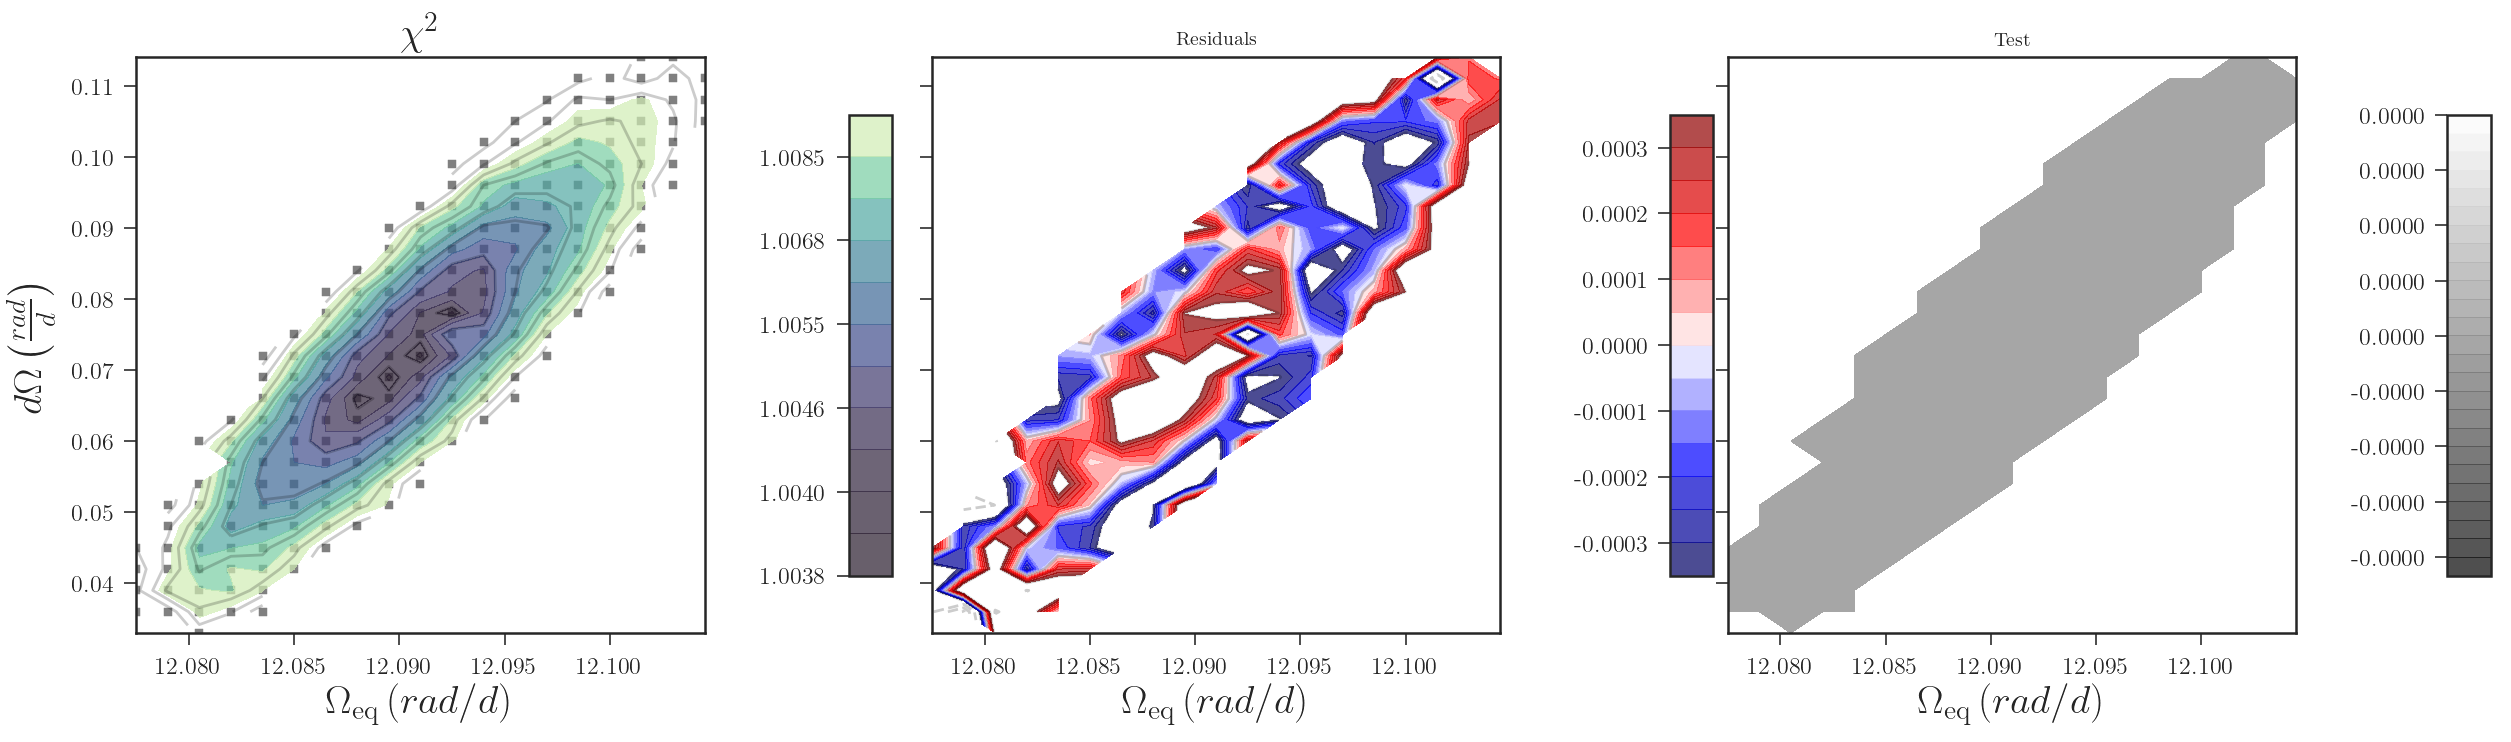

In [12]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import copy
cmap = copy.copy(cmocean.cm.deep_r)

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=1.)
#ax[0].scatter(Oeq, dO, c=chisq, cmap=cmap, marker = 's', s=80, alpha=1.)
ax[0].set_title(r'$\chi^2$', fontsize=20)
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='w')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$', fontsize=20)


# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

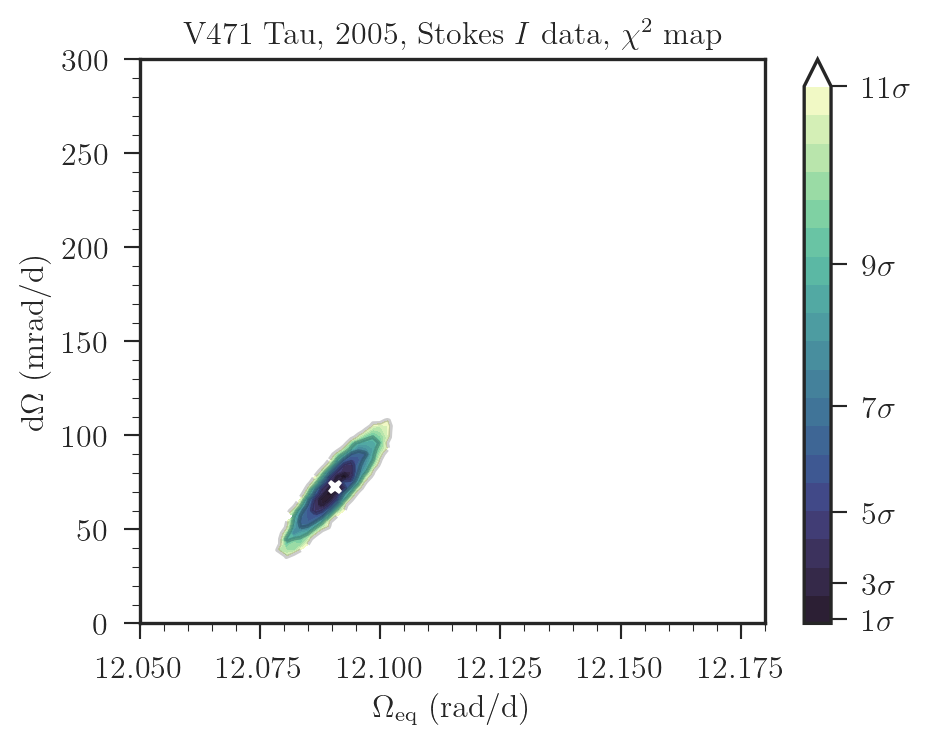

In [13]:
fig, ax = P.subplots(1,1, figsize=(5,4), dpi=96)
#ax.scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'V471 Tau, 2005, Stokes $I$ data, $\chi^2$ map', fontsize='large')
im = ax.contourf(x, 1.e3*y, z, levels=N.linspace(lev[0], lev[-1], 20), cmap=cmap, alpha=1., extend='max')
im.cmap.set_over('white')
ax.contour(x, 1.e3*y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
cbar.solids.set_edgecolor("face")
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
#ax.set_xlim((12.08,12.1)); ax.set_ylim((0.050,0.090))
ax.plot(best_x, 1.e3*best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega$ (mrad/d)', fontsize='large')
ax.set_xlabel(r'$\Omega_\mathrm{eq}$ (rad/d)', fontsize='large')
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(.005))
P.xticks(fontsize='large')
P.yticks(fontsize='large')
P.tight_layout()
P.savefig('figs/dr_i_chipot_2005.pdf', rasterized=True, dpi=96)

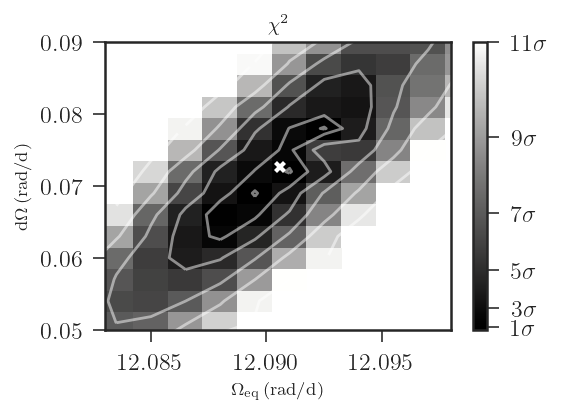

In [14]:
fig, ax = P.subplots(1,1, figsize=(4,3))
ax.set_title(r'$\chi^2$')
x_l = N.unique(Oeq)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(dO)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=copy.copy(cm.cm.gray), alpha=1.)
im.cmap.set_over('white')
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.set_xlim((12.083,12.098)); ax.set_ylim((0.050,0.090))
ax.plot(best_x, best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega \left(\mathrm{rad/d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(\mathrm{rad/d}\right)$')
P.tight_layout()

### Stokes $V $ 
\begin{equation*} |B_{\mathrm{aim}}| = 145 \end{equation*}

In [15]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

#Define the number of sigmas that you want to consider 
nsigma=5.

# Read file with informations in each run
beta_v, gamma_v, chisq_v, s_v, bmod, test_v = N.genfromtxt('data/search_DRv_chipot_2005.txt', unpack=True)


#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
print(Omega0)
Oeq_v = (1 - beta_v)*Omega0
dO_v = gamma_v*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_05.ss')

count=0
for i in range(len(cycleV)):
    count += V[i].shape[0]
print('n points =', count)
    
#Compute the corresponding variation in "reduced chisq"
dchisq_v = nsigma**2*2.3/count

#select data within the conditions:
isp = N.bitwise_and(N.bitwise_and(bmod <= 145.05, bmod >= 144.75), test_v <=0.005)
Oeq_v = Oeq_v[isp]; dO_v = dO_v[isp]; chisq_v = chisq_v[isp]; s_v = s_v[isp]; bmod = bmod[isp] 
test_v = test_v[isp]

# Set global min of spot coverage
vmin_v = chisq_v.min()
print(vmin_v)
#Set levels for plotting
lev_v = [vmin_v + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1_v = [vmin_v + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#we also add another condition for the data (optional):
ic_v = N.bitwise_and(chisq_v >= vmin_v, chisq_v <= (vmin_v + cut_sigma**2*2.3/count))
Oeq_v = Oeq_v[ic_v]; dO_v = dO_v[ic_v]; chisq_v = chisq_v[ic_v]; s_v = s_v[ic_v]; bmod = bmod[ic_v] 
test_v = test_v[ic_v]

# Create a mesh and create new matrix with mesh's shape
x_v, y_v = N.meshgrid(N.unique(Oeq_v), N.unique(dO_v))
m_z_v = N.ones_like(x_v)*9999.
m_test_v = N.ones_like(x_v)*9999.
for i in range(chisq_v.shape[0]):
    indx = N.bitwise_and(x_v == Oeq_v[i], y_v == dO_v[i])
    m_z_v[indx] = chisq_v[i]
    m_test_v[indx] = test_v[i]
mask_v = m_z_v > (vmin_v + cut_sigma**2*2.3/count)
z_v=N.ma.array(m_z_v, mask=mask_v)  
mask1_v = m_test_v >= 1.
c_test_v=N.ma.array(m_test_v, mask=mask1_v) 

print(' Number of points in the fit: ', Oeq_v.shape[0])
print('\n The lowest Chi2 in the data was at:')
print('Oeq = ', Oeq_v[chisq_v.argmin()], 'dO = ', dO_v[chisq_v.argmin()])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq_v**2 + x[1]*Oeq_v + x[2]*dO_v**2 + x[3]*dO_v \
                            + x[4]*Oeq_v*dO_v + x[5] - chisq_v
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx /= N.sqrt(count)
dy /= N.sqrt(count)

w_min_v = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res_v = a*Oeq_v**2 + b*Oeq_v + c*dO_v**2 + d*dO_v + e*Oeq_v*dO_v + f - chisq_v


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.3f and d(dO) = %1.3f \n' %(dx, dy))



thc = N.arccos(N.sqrt((best_x-Omega0)/best_y))
dthc = 1./(1 - (best_x - Omega0)/best_y)*N.sqrt((1./2./best_y/N.sqrt((best_x - Omega0)/best_y)*dx)**2 + ((best_x - Omega0)/2./best_y**2/N.sqrt((best_x - Omega0)/best_y)*dy)**2)

print('(theta_c) = %d +- %d \n' %(thc*180./N.pi, dthc*180./N.pi) )



cos2theta_05V = e/(c-a-N.sqrt((a-c)**2 + e**2))
ws_05V = best_x - best_y*(cos2theta_05V)
print(r'cos2(theta_s) = %.3f' %(cos2theta_05V))
print('(theta_s) = %.3f ' %(N.arccos(N.sqrt(cos2theta_05V))*180./N.pi))
print('(Omega_s) = %.3f \n' %(ws_05V))


thetas_wiki = N.arctan(e/(c-a))/2.
print('(theta_s) = %.3f \n' %(N.arccos(N.sqrt(N.tan(thetas_wiki)))*180./N.pi))

print(r'beta = %.8f and gamma = %.8f' %(1.- best_x/Omega0, best_y/Omega0))

Oeq05V = best_x; dO05V = best_y
dOeq05V = dx; ddO05V = dy

print('\n Min chisq from fit:')
print('Min chisq = ', w_min_v)
print('RMS = ', N.sqrt(N.mean(res_v**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res_v**2))*(count/2.3)) #2params

12.055613163954858
n points = 11590
1.1047
 Number of points in the fit:  379

 The lowest Chi2 in the data was at:
Oeq =  12.083000020935547 dO =  0.047000013480994404
Position of the center on this plane:
Omega_EQ = 12.083 and dO = 0.048
dOeq = 0.004 and d(dO) = 0.012 

(theta_c) = 40 +- 15 

cos2(theta_s) = 0.271
(theta_s) = 58.650 
(Omega_s) = 12.070 

(theta_s) = 58.650 

beta = -0.00228950 and gamma = 0.00397742

 Min chisq from fit:
Min chisq =  1.1047897042726618
RMS =  0.00010435715802306899
RMS x dchisq = 0.525869331081465


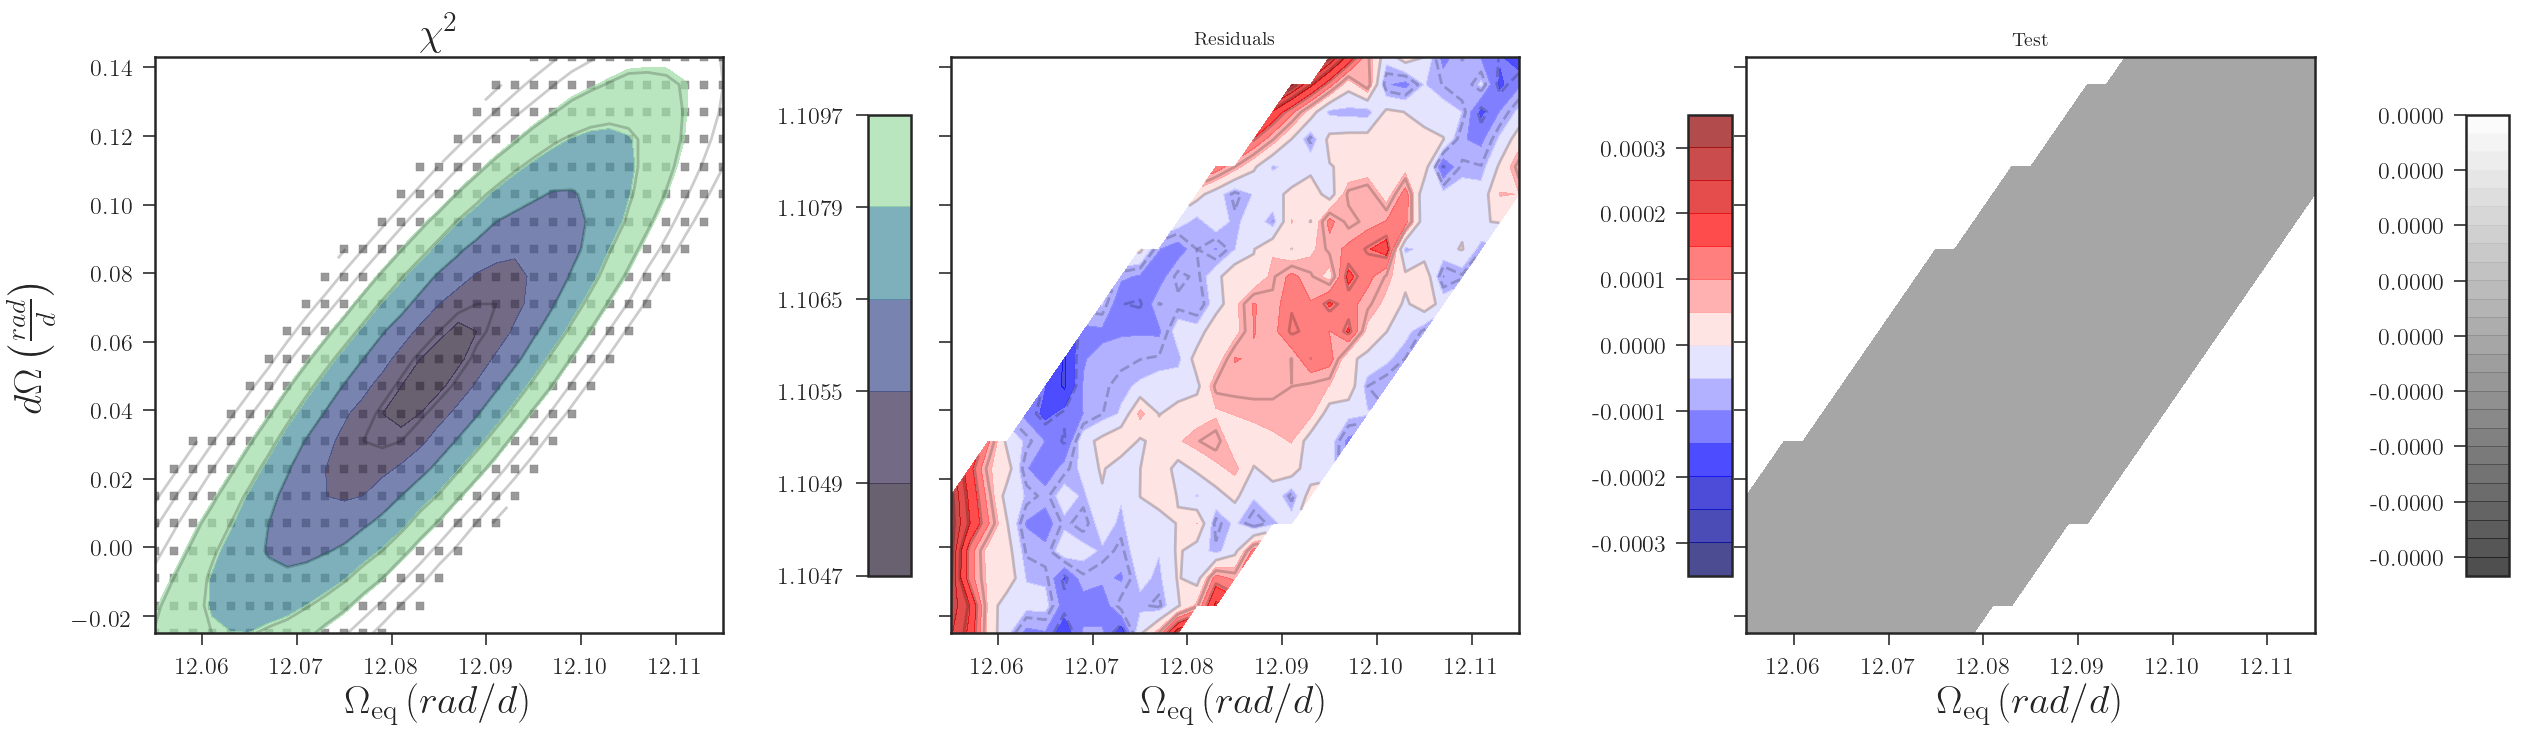

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(Oeq_v, dO_v, marker = 's', s=20, color='gray', alpha=0.8)
#ax[0].scatter(x_v, y_v, c=z_v, marker = 's', s=20, alpha=1.)
ax[0].set_title(r'$\chi^2$', fontsize=20)
im = ax[0].contourf(x_v, y_v, z_v, levels=lev_v, cmap=cmap, alpha=0.7)
ax[0].contour(x_v, y_v, z_v, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x_v.min(), x_v.max()))
ax[0].set_ylim((y_v.min(), y_v.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$', fontsize=20)

# Residual
res_v = a*x_v**2 + b*x_v + c*y_v**2 + d*y_v + e*x_v*y_v + f - z_v
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x_v, y_v, res_v, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x_v, y_v, res_v, colors='k', alpha=0.2)
ax[1].set_xlim((x_v.min(), x_v.max()))
ax[1].set_ylim((y_v.min(), y_v.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x_v, y_v, c_test_v, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x_v.min(), x_v.max()))
ax[2].set_ylim((y_v.min(), y_v.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

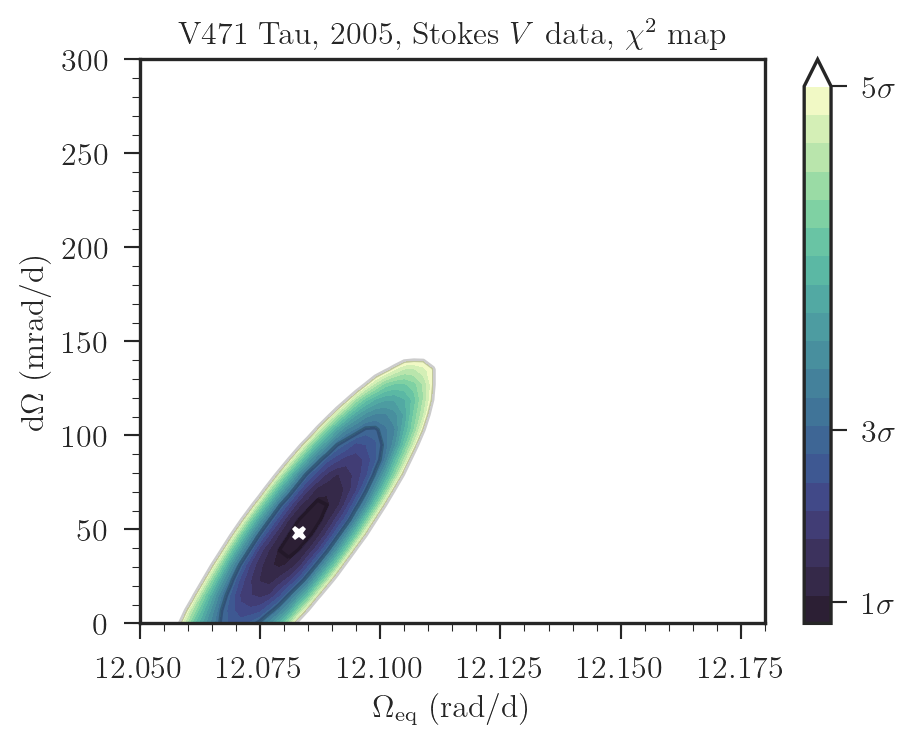

In [17]:
fig, ax = P.subplots(1,1, figsize=(5,4), dpi=96)
#ax.scatter(Oeq_v, dO_v, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'V471 Tau, 2005, Stokes $V$ data, $\chi^2$ map', fontsize='large')
im = ax.contourf(x_v, 1.e3*y_v, z_v, levels=N.linspace(lev_v[0], lev_v[-1], 20), cmap=cmap, alpha=1., extend='max')
im.cmap.set_over('white')
ax.contour(x_v, 1.e3*y_v, z_v, levels=lev_1_v, colors='k', alpha=.2)
cbar = fig.colorbar(im, ticks=lev_1_v, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.plot(best_x, 1.e3*best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega$ (mrad/d)', fontsize='large')
ax.set_xlabel(r'$\Omega_\mathrm{eq}$ (rad/d)', fontsize='large')
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(.005))
P.xticks(fontsize='large')
P.yticks(fontsize='large')
P.tight_layout()
P.savefig('figs/dr_v_chipot_2005.pdf', rasterized=True, dpi=96)

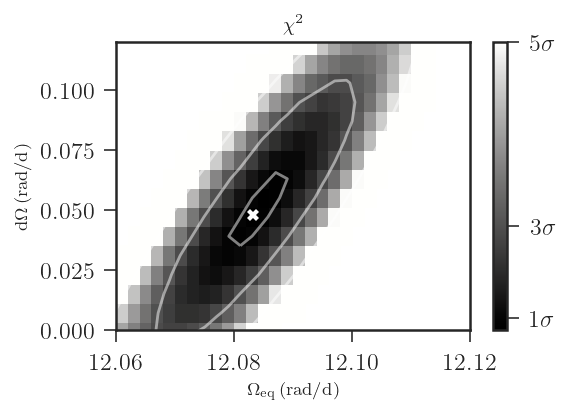

In [18]:
fig, ax = P.subplots(1,1, figsize=(4,3))
ax.set_title(r'$\chi^2$')
x_l = N.unique(Oeq_v)[0:2]
dx_v = (x_l[1] - x_l[0])/2.
y_l = N.unique(dO_v)[0:2]
dy_v = (y_l[1] - y_l[0])/2.
im_v = ax.pcolormesh(x_v-dx_v, y_v-dy_v, z_v, vmin=lev_v[0], vmax=lev_v[-1], cmap=copy.copy(cm.cm.gray), alpha=1.)
im.cmap.set_over('white')
ax.contour(x_v, y_v, z_v, levels=lev_1_v, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im_v, ticks=lev_1_v, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.set_xlim((12.06,12.12)); ax.set_ylim((0.00,0.12))
ax.plot(best_x, best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega \left(\mathrm{rad/d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(\mathrm{rad/d}\right)$')
P.tight_layout()

### DATA IN 2014 
  \begin{equation*} SP_{\mathrm{ph}} = 0.13 \end{equation*}

In [19]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq
import cmocean as cm
import matplotlib.font_manager

#Define the number of sigmas that you want to consider 
nsigma = 15.

# Read file with informations in each run
beta, gamma, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_DRi_chipot_2014.txt', unpack=True)


#Change to oeq and do
period =  0.5211833875 # in days
Omega0 = 2*N.pi/period
print(Omega0)
Oeq = (1 - beta)*Omega0
dO = gamma*Omega0

# Now we need to find the number of points to find the error bar
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_14.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
print('n pooints', count)    
#Compute the corresponding variation in "reduced chisq"
dchisq = nsigma**2*2.3/count

#select data within the conditions:
isp = N.bitwise_and(N.bitwise_and(sp_ph <= 0.13050, sp_ph >= 0.12950), test <=0.005)
Oeq = Oeq[isp]; dO = dO[isp]; chisq = chisq[isp]; s = s[isp]; sp_ph = sp_ph[isp] 
test = test[isp]; cool = cool[isp]; hot = hot[isp]

# Set global min of spot coverage
vmin = chisq.min()
print(vmin)

#Set levels for plotting
lev = [vmin + isigma**2*(2.3/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [vmin + isigma**2*(2.3/count) for isigma in range(1,cut_sigma,2)]

#we also add another condition for the data (optional):
ic = N.bitwise_and(chisq >= vmin, chisq <= (vmin + cut_sigma**2*2.3/count))
Oeq = Oeq[ic]; dO = dO[ic]; chisq = chisq[ic]; s = s[ic]; sp_ph = sp_ph[ic] 
test = test[ic]; cool = cool[ic]; hot = hot[ic]

# Create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(N.unique(Oeq), N.unique(dO))
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(chisq.shape[0]):
    indx = N.bitwise_and(x == Oeq[i], y == dO[i])
    m_z[indx] = chisq[i]
    m_test[indx] = test[i]
mask = m_z > (vmin + cut_sigma**2*2.3/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1) 

#import matplotlib.tri as tri
## Perform linear interpolation of the data (x,y)
## on a grid defined by (xi,yi)
#triang = tri.Triangulation(Oeq, dO)
#interpolator = tri.LinearTriInterpolator(triang, chisq)
#z = interpolator(x, y)
#interpolator_test = tri.LinearTriInterpolator(triang, test)
#c_test = interpolator_test(x, y)


print(' Number of points in the fit: ', Oeq.shape[0])
print('\n The lowest Chi2 in the data was at:')
print('Oeq = ', Oeq[chisq.argmin()], 'dO = ', dO[chisq.argmin()],"\n")

# find center in the 2d-plane
optimize_func = lambda x: x[0]*Oeq**2 + x[1]*Oeq + x[2]*dO**2 + x[3]*dO \
                            + x[4]*Oeq*dO + x[5] - chisq
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)
dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))

dx *= sigma_errorbar/N.sqrt(count)
dy *= sigma_errorbar/N.sqrt(count)

w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f 
res = a*Oeq**2 + b*Oeq + c*dO**2 + d*dO + e*Oeq*dO + f - chisq


print('Position of the center on this plane:')
print(r'Omega_EQ = %.3f and dO = %.3f' %(best_x, best_y))
print('dOeq = %.4f and d(dO) = %1.3f \n' %(dx, dy))


thc = N.arccos(N.sqrt((best_x-Omega0)/best_y))
dthc = 1./(1 - (best_x - Omega0)/best_y)*N.sqrt((1./2./best_y/N.sqrt((best_x - Omega0)/best_y)*dx)**2 + ((best_x - Omega0)/2./best_y**2/N.sqrt((best_x - Omega0)/best_y)*dy)**2)

print('(theta_c) = %d +- %d \n' %(thc*180./N.pi, dthc*180./N.pi) )


cos2theta_14I = e/(c-a-N.sqrt((a-c)**2 + e**2))
ws_14I = best_x - best_y*(cos2theta_14I)
print(r'cos2(theta_s) = %.3f' %(cos2theta_14I))
print('(theta_s) = %.3f ' %(N.arccos(N.sqrt(cos2theta_14I))*180./N.pi))
print('(Omega_s) = %.3f \n' %(ws_14I))


thetas_wiki = N.arctan(e/(c-a))/2.
print('(theta_s) = %.3f \n' %(N.arccos(N.sqrt(N.tan(thetas_wiki)))*180./N.pi))

print(r'beta = %.8f and gamma = %.8f' %(1.- best_x/Omega0, best_y/Omega0))

Oeq14 = best_x; dO14 = best_y
dOeq14 = dx; ddO14 = dy

print('\n Min chisq from fit:')
print('Min chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

12.055613163954858
n pooints 28792
1.0282
 Number of points in the fit:  49

 The lowest Chi2 in the data was at:
Oeq =  12.083000020935547 dO =  0.05600001093241327 

Position of the center on this plane:
Omega_EQ = 12.085 and dO = 0.064
dOeq = 0.0003 and d(dO) = 0.001 

(theta_c) = 47 +- 0 

cos2(theta_s) = 0.232
(theta_s) = 61.190 
(Omega_s) = 12.070 

(theta_s) = 61.190 

beta = -0.00244048 and gamma = 0.00528876

 Min chisq from fit:
Min chisq =  1.0288072171097156
RMS =  0.001652508718671995
RMS x dchisq = 20.686535229566992


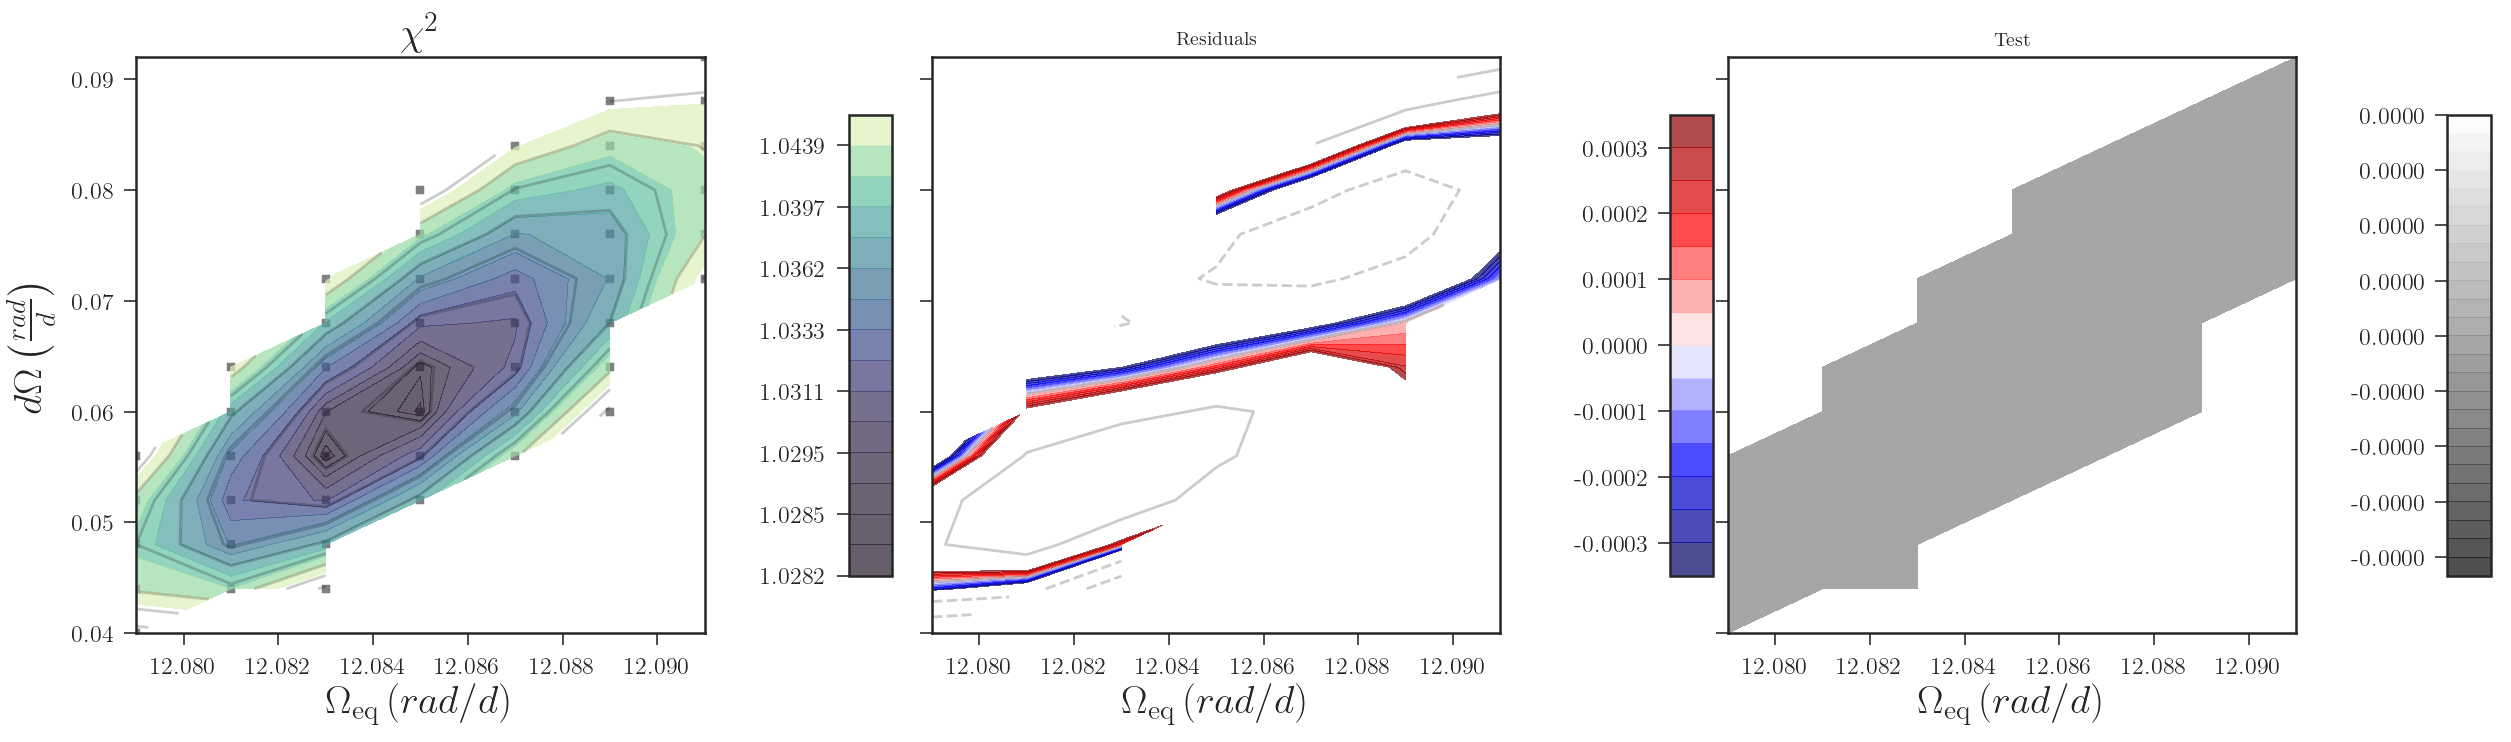

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import copy
cmap = copy.copy(cmocean.cm.deep_r)

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=1.)
#ax[0].scatter(Oeq, dO, c=chisq, cmap=cmap, marker = 's', s=80, alpha=1.)
ax[0].set_title(r'$\chi^2$', fontsize=20)
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%.4f')
cbar.ax.set_xticklabels([r'%d \sigma' %i for i in range(0,int(nsigma)+1)])
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='w')
ax[0].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
ax[0].set_ylabel(r'$d\Omega \left(\frac{rad}{d}\right)$', fontsize=20)


# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, levels=N.linspace(-1,1,15)*4.e-4, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].set_xlabel(r'$\Omega_\mathrm{eq} \left(rad/d\right)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()

P.show()

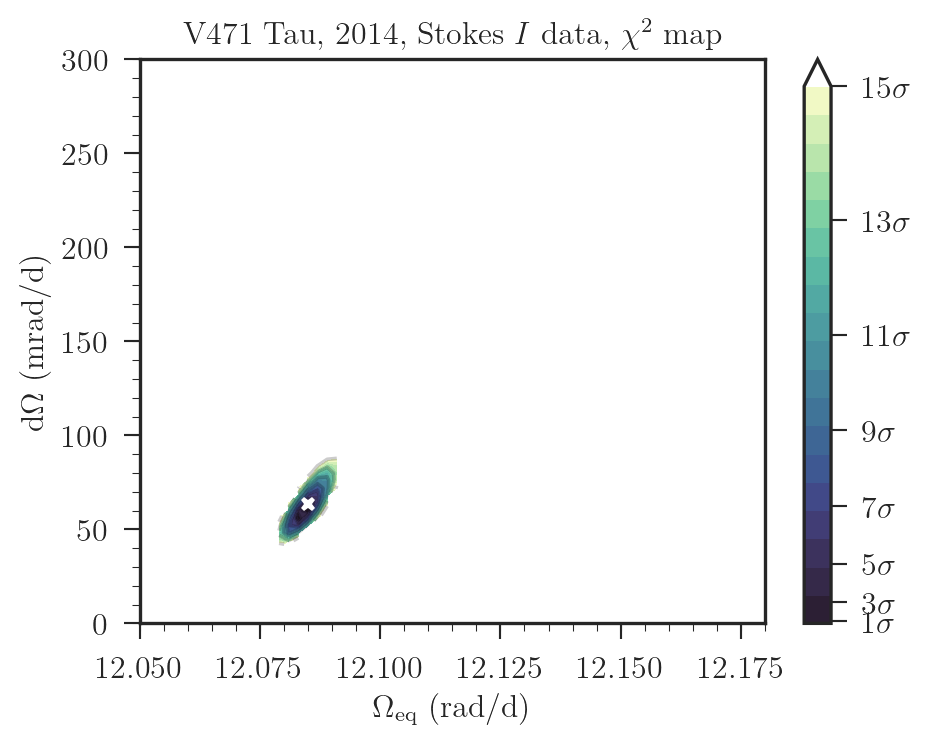

In [21]:
fig, ax = P.subplots(1,1, figsize=(5,4), dpi=96)
#ax.scatter(Oeq, dO, marker = 's', s=20, color='gray', alpha=0.8)
ax.set_title(r'V471 Tau, 2014, Stokes $I$ data, $\chi^2$ map', fontsize='large')
im = ax.contourf(x, 1.e3*y, z, levels=N.linspace(lev[0], lev[-1], 20), cmap=cmap, alpha=1., extend='max')
im.cmap.set_over('white')
ax.contour(x, 1.e3*y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
cbar.solids.set_edgecolor("face")
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
#ax.set_xlim((12.08,12.1)); ax.set_ylim((0.050,0.090))
ax.plot(best_x, 1.e3*best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega$ (mrad/d)', fontsize='large')
ax.set_xlabel(r'$\Omega_\mathrm{eq}$ (rad/d)', fontsize='large')
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(.005))
P.xticks(fontsize='large')
P.yticks(fontsize='large')
P.tight_layout()
P.savefig('figs/dr_i_chipot_2014.pdf', rasterized=True, dpi=96)

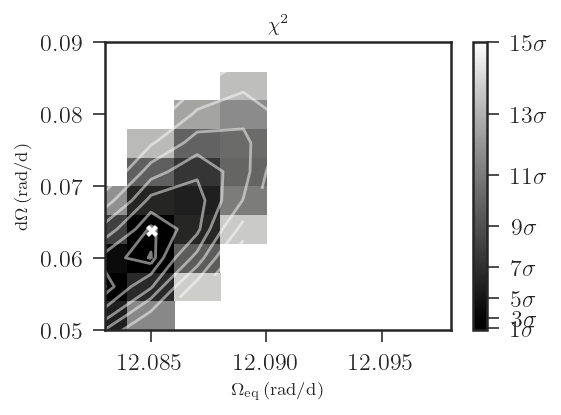

In [22]:
fig, ax = P.subplots(1,1, figsize=(4,3))
ax.set_title(r'$\chi^2$')
x_l = N.unique(Oeq)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(dO)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=copy.copy(cm.cm.gray), alpha=1.)
im.cmap.set_over('white')
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_o); ax.set_ylim(lev_do)
ax.set_xlim((12.083,12.098)); ax.set_ylim((0.050,0.090))
ax.plot(best_x, best_y, 'X', color='w')
ax.set_ylabel(r'$\mathrm{d}\Omega \left(\mathrm{rad/d}\right)$')
ax.set_xlabel(r'$\Omega_\mathrm{eq} \left(\mathrm{rad/d}\right)$')
P.tight_layout()

In [23]:
period =  0.521183398 # in days
Omega0 = 2*N.pi/period
print(Omega0)
scale=1e3


polynom =  N.polyfit(N.array([0, dO04, dO04V, dO05, dO05V, .0016])*scale, [Omega0, Oeq04, Oeq04V, Oeq05, Oeq05V, 12.0547], deg = 1)
#polynom =  N.polyfit(N.array([0, dO04, dO04V, dO05, dO05V])*scale, [Omega0, Oeq04, Oeq04V, Oeq05, Oeq05V], deg = 1)

fits = N.poly1d(polynom)


########################
# FIT FROM ORIGIN:     #
# -------------------- #
#  y = a + bx          #
# -------------------- #
# WITHOUT ERROR        #
# a = 12.056 +- 0.002  #
# b = 0.49 +- 0.02     #
# -------------------- #
# WITH ERROR          #
# a = 12.057 +- 0.003  #
# b = 0.48 +- 0.03     #
########################


12.055612921076941


In [24]:
print(fits)
print(fits[1]*scale)
print(fits[0])

 
0.0004836 x + 12.06
0.4836186395716903
12.056081863617592


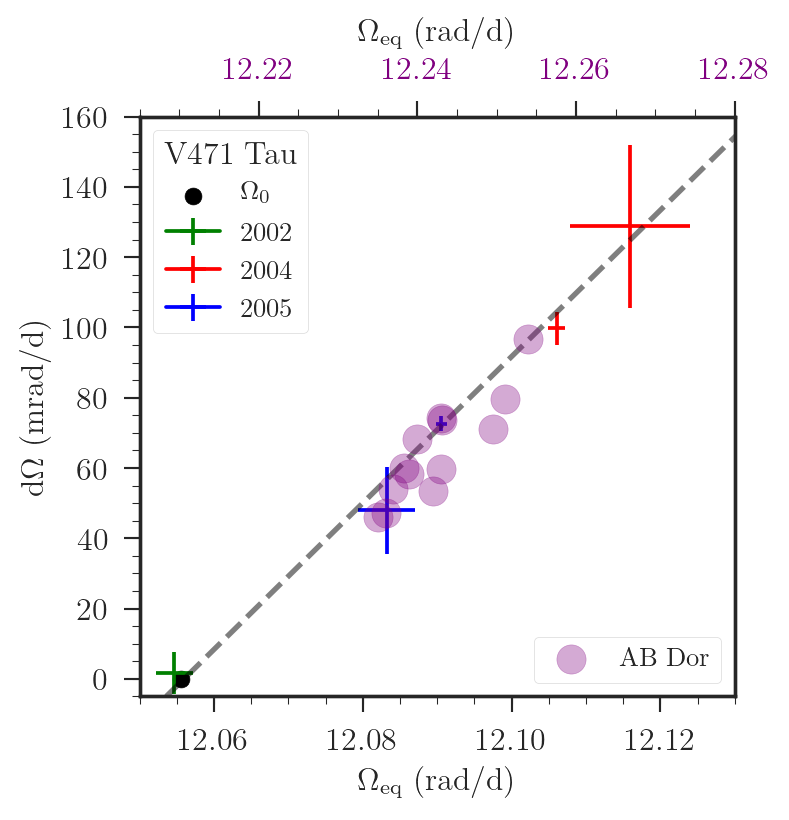

In [25]:
fig, ax = P.subplots(1,1, figsize=(4,4), dpi=96)
xrange = N.arange(-5,160,8)
P.plot(12.056 + 0.00048*xrange, xrange, '--k', linewidth=2, alpha=0.5)

# ABdor:
ax2 = ax.twiny()
OeqABdor = N.array([12.242, 12.236, 12.239, 12.235, 12.237, 12.254, 12.243, 12.251, 12.243, 12.240])
dOABdor = N.array([53.4, 47.1, 58.4, 46.1, 54.0, 96.7, 59.6, 79.5, 74.1, 68.2])
ax2.scatter(OeqABdor, dOABdor, marker='o', color='purple', s=120, alpha=1./3, label=r'AB Dor')
# from Jeffers et al. 2007
OeqABdor_jeff = N.array([12.2383, 12.2495, 12.2431])
dOABdor_jeff = N.array([60.1, 71.1, 73.6])
ax2.scatter(OeqABdor_jeff, dOABdor_jeff, marker='o', color='purple', s=120, alpha=1./3)
#

# 
ax.scatter(Omega0, 0, s=40,marker='o', color='k', label=r'$\Omega_0$')      #Solid body
ax.errorbar( 12.0547, 1.6,  xerr=0.0025, yerr=6,color='g', label=r"$2002$") #Gaitee et al. 2006

# This work:
ax.errorbar( Oeq04, scale*dO04, xerr=dOeq04, yerr=scale*ddO04, color='r', label=r'$2004$')
ax.errorbar(Oeq04V, scale*dO04V, xerr=dOeq04V, yerr=scale*ddO04V,color='r')
ax.errorbar( Oeq05, scale*dO05,xerr=dOeq05, yerr=scale*ddO05,color='b', label=r'$2005$')
ax.errorbar(Oeq05V,  scale*dO05V, xerr=dOeq05V, yerr=scale*ddO05V,color='b')


P.ylabel(r'$\mathrm{d}\Omega$ (mrad/d)', fontsize='large')
P.xlabel(r'$\Omega_\mathrm{eq}$ (rad/d)', fontsize='large')
P.ylim((-5,160)); ax.set_xlim((12.05,12.130)); ax2.set_xlim((12.205,12.28))
P.yticks(fontsize='large')
P.xticks(fontsize='large')
ax.set_ylabel(r'$\mathrm{d}\Omega$ (mrad/d)', fontsize='large')
ax.set_xlabel(r'$\Omega_\mathrm{eq}$ (rad/d)', fontsize='large')
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(.005))
ax2.xaxis.set_minor_locator(MultipleLocator(.005))
ax2.tick_params(axis='x', labelcolor='purple')
P.yticks(fontsize='large')
P.xticks(fontsize='large')
leg = ax.legend(fontsize='medium', frameon=True)
leg.set_title('V471 Tau',prop={'size':'large'})
ax2.legend(fontsize='medium', loc='lower right', frameon=True)
P.savefig('figs/diff_rot.pdf', bbox_inches='tight', dpi=96)
P.savefig('figs/diff_rot.png', bbox_inches='tight', dpi=96)

In [26]:
period =  0.521183398 # in days
Omega0 = 2*N.pi/period
convert=180./N.pi
print('Omega_0 = ', Omega0)
print('\n') 
print('Oeq_04I/Omega_0 =', Oeq04/Omega0)
print('Oeq_04V/Omega_0 =', Oeq04V/Omega0)
print('\n') 
print('Oeq_05I/Omega_0 =', Oeq05/Omega0)
print('Oeq_05V/Omega_0 =', Oeq05V/Omega0)

Omega_0 =  12.055612921076941


Oeq_04I/Omega_0 = 1.0041849013686508
Oeq_04V/Omega_0 = 1.005001842257667


Oeq_05I/Omega_0 = 1.0029006163506269
Oeq_05V/Omega_0 = 1.0022895165069845


In [27]:
## AB Dor parameters in cgs
alpha = 0.58; mu = 0.027; mc = 0.074*1.989e33
R = 1.04*6.955e10
dOmin = 0.060/(24.*3600.)
dOvar = 0.040/(24.*3600.)

dKabdor = alpha/3.*mc*R**2*mu*(dOvar**2 + 2*dOvar*dOmin)

print(dKabdor)

## For V471 Tau assuming some parameters from AB Dor validy
# R = 0.93709*6.955e10  # K dwarf's radii
R = 1.04*6.955e10

dOmin = 0.058/(24.*3600.)
dOvar = 0.064/(24.*3600.)

dK = alpha/3.*mc*R**2*mu*(dOvar**2 + 2*dOvar*dOmin)

print(dK)

Lsun  = 3.839e33 # ergs
Lmean = 10**(2./5.*(4.74-5.677))*3.839e33

ts = 30.*365.*24.*3600. # 1./4 of the period of ETV

print((dK/ts)/Lmean)
print((dK)/(15.*365.*24.*3600*0.4*Lsun))



3.446279067254978e+39
6.20330232105896e+39
0.004048339942812518
0.008539785804167043


In [28]:
### Yuan and Qian 2007

M   = 0.9971
Mwd = 0.8778
R   = 0.93709
Rwd = 0.01057
a   = 3.3608
dpp = 1.8e-6 

Brms = 1.2e3*a*(M*Mwd*dpp/(R*Rwd)**3)**0.5  # In Tesla

In [29]:
OeqABdor = N.array([12.242, 12.236, 12.239, 12.235, 12.237, 12.254, 12.243, 12.251, 12.243, 12.240])
dOABdor = N.array([0.0534, 0.0471, 0.0584, 0.0461, 0.0540, 0.0967, 0.0596, 0.0795, 0.0741, 0.0682])
OsbABdor = 12.2053

print('_____ Position of the structures in AB Dor   _____ \n')
print(N.sqrt(0.48*dOABdor/(dOABdor-OeqABdor+OsbABdor)))

print('\n') 
print('_____ Position of the structures in V471 Tau _____\n')

print(N.sqrt(0.48*dOABdor/(dOABdor-OeqABdor+OsbABdor)))
print('___2004___')
print('Stokes I  r = %.3f'    %N.sqrt(0.48*dO04/(dO04-Oeq04+Omega0)))
print('Stokes V  r = %.3f \n' %N.sqrt(0.48*dO04V/(dO04V-Oeq04V+Omega0)))
print('___2005___')
print('Stokes I  r = %.3f'    %N.sqrt(0.48*dO05/(dO05-Oeq05+Omega0)))
print('Stokes V  r = %.3f'    %N.sqrt(0.48*dO05V/(dO05V-Oeq05V+Omega0)))


_____ Position of the structures in AB Dor   _____ 

[1.23889075 1.17411098 1.06531628 1.16158008 1.07811495 0.98336158
 1.14293542 1.06254133 0.98850537 0.98853125]


_____ Position of the structures in V471 Tau _____

[1.23889075 1.17411098 1.06531628 1.16158008 1.07811495 0.98336158
 1.14293542 1.06254133 0.98850537 0.98853125]
___2004___
Stokes I  r = 0.986
Stokes V  r = 0.950 

___2005___
Stokes I  r = 0.962
Stokes V  r = 1.064


In [30]:
print('---- Relative Shears -----\n')
print('___2004___')
print('dO/Oeq I = %.3f' %(dO04/Oeq04))
print('dO/Oeq V = %.3f \n' %(dO04V/Oeq04V))
print('___2005___')
print('dO/Oeq I = %.3f' %(dO05/Oeq05))
print('dO/Oeq V = %.3f' %(dO05V/Oeq05V))

---- Relative Shears -----

___2004___
dO/Oeq I = 0.008
dO/Oeq V = 0.011 

___2005___
dO/Oeq I = 0.006
dO/Oeq V = 0.004


In [31]:
E = 730 # number of cycles between both data sets
print('----- Time laps ------')
print('___2005___')
print('dPhase I = %.3f'  %((ws_05I - Omega0)/(2.*N.pi)*E))
print('dPhase V = %.3f\n'  %((ws_05V - Omega0)/(2.*N.pi)*E))

print('__ Time lap___')
print('dPhase I = %.3f' %((Oeq05 - dO05*N.cos(30*N.pi/180.)**2 - Omega0)/(2.*N.pi)*E))
print('dPhase V = %.3f' %((Oeq05V - dO05V*N.cos(30.6*N.pi/180.)**2 - Omega0)/(2.*N.pi)*E))



----- Time laps ------
___2005___
dPhase I = 1.567
dPhase V = 1.699

__ Time lap___
dPhase I = -2.266
dPhase V = -0.921


In [32]:
((12.089 - 0.058*N.cos(57.*N.pi/180.)**2 - Omega0)/(2.*N.pi)*E)

1.8801263642901225

In [33]:
((12.069 - 12.0556)/(2.*N.pi)*E)

1.5568536533250068